## Data Science Salaries Prediction

Throughout the past few years, data science jobs have become more in demand than ever, with the U.S. Bureau of Labor Statistics predicting data science to see more growth than almost any other field between now and 2029 (Davenport, 2022). 

Data science is a varied field, with a wide range of work that involves performing robust analytics (Anderson, 2018). Therefore, the dataset "Data Science Job Salaries" found on Kaggle provides valuable insights into professions in data science, as it is a collection of salary records for data science professionals across various countries from the years 2020 to 2022. This data provides a snapshot of the data science job market, offering insights into salary trends, the impact of geographical location, and the influence of remote work on compensation. There are 11 variables total:

**Categorical variables:**
- **work_year**: the year in which the salary was paid
- **experience_level**: the experience level in job, which can be entry-level/junior (EN), mid-level/intermediate (MI), senior-level/expert (SE), executive-level/senior (EX)
- **employment_type**: the type of employment for the role, which can be part-time (PT), full-time (FT), contract (CT) or freelance (FL)
- **job_title**: role of the employee
- **employee_residence**: the employee's primary country of residence, expressed using ISO 3166 country codes
- **remote_ratio**: the overall ratio of work done remotely, which can be no remote work or less than 20% (0), partially remote (50) or fully remote or more than 80% (100)
- **company_location**: the country where the employer's main office/contracting branch is located, expressed using ISO 3166 country codes. 
- **company_size**: the average number of people working for the company, which can be less than 50 employees (S), 50 to 250 employees (M) or more than 250 employees (L)
- **salary_currency**: the currency of the salary, expressed using ISO 4217 currency codes

**Continuous variables:**
- **salary**: the total gross salary paid to employee
- **salary_in_usd**: salary converted to USD using the average exchange rate of the work year

### Question

Our investigation involves both inference and prediction. The first question we aim to answer is

> "How does the level of experience (experience_level), the mode of work (remote_ratio), and company size (company_size) influence the salaries (salary_in_usd) of data science professionals in the United States, from 2020 to 2022?".

We will then look into the question:

> "What variables (out of the three mentioned in the previous question) best predict one's salary?". 

These questions are worth investigating as numerous reports have emphasized the impact of factors such as experience level and company size on one's salary. For instance, *Innovation, Science, Economic Development Canada* has stated that large firms pay higher wages than small firms (Innovation, Science, Economic Development Canada, 2023).


## Methods and Results

### Exploratory Data Analysis (EDA)

In [14]:
#Loading the packages we need
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(leaps)
library(mltools)

options(repr.plot.width = 15, repr.plot.height = 15)
options(repr.matrix.max.rows = 6)

In [15]:
#Grabbing data
url <- "https://raw.githubusercontent.com/jsscachen/Data-Science-Salaries-Prediction/main/ds_salaries.csv"

#Reading into R
ds_salaries <- read_csv(url) %>%               
                    mutate(remote_ratio = as.factor(remote_ratio)) # converting numerical variable of remote_ratio into a factor, as it is a categorical variable.
                    

ds_salaries

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


To tidy the data, we will omit some variables to focus on the variables that will help us address the question of interest. We have decided to focus on the data entries for companies located in the United States, as there are 50 levels for the variable "company_location" and the majority of locations have too little data points to provide for a significant analysis, as shown below. 

In [16]:
#Calculating percentage of each level for company_location
level_counts <- table(ds_salaries$company_location)

most_common_location <- (level_counts/(length(ds_salaries$company_location)))*100

most_common_location


        AE         AS         AT         AU         BE         BR         CA 
 0.4942339  0.1647446  0.6589786  0.4942339  0.3294893  0.4942339  4.9423394 
        CH         CL         CN         CO         CZ         DE         DK 
 0.3294893  0.1647446  0.3294893  0.1647446  0.3294893  4.6128501  0.4942339 
        DZ         EE         ES         FR         GB         GR         HN 
 0.1647446  0.1647446  2.3064250  2.4711697  7.7429984  1.8121911  0.1647446 
        HR         HU         IE         IL         IN         IQ         IR 
 0.1647446  0.1647446  0.1647446  0.1647446  3.9538715  0.1647446  0.1647446 
        IT         JP         KE         LU         MD         MT         MX 
 0.3294893  0.9884679  0.1647446  0.4942339  0.1647446  0.1647446  0.4942339 
        MY         NG         NL         NZ         PK         PL         PT 
 0.1647446  0.3294893  0.6589786  0.1647446  0.4942339  0.6589786  0.6589786 
        RO         RU         SG         SI         TR         

As we can see, the United States (US) has approximately 58% of the data points, while the other points have less than 10%. Likewise, as an overwhelming percentage of data points are "Full Time (FT)", we can focus on full time jobs.

In [17]:
#Calculating percentage of each level for employment_type
level_counts <- table(ds_salaries$employment_type)

most_common_type <- (level_counts/(length(ds_salaries$employment_type)))*100

most_common_type


        CT         FL         FT         PT 
 0.8237232  0.6589786 96.8698517  1.6474465 

We can see that 97% of the data points are "FT". We are now ready to tidy our data!

In [18]:
#Tidying data 
ds_salaries <- ds_salaries %>%
     filter(employment_type == "FT",  
         company_location == "US") %>%
         select(salary_in_usd, experience_level, remote_ratio, company_size)

# Checking to see if any of the rows/values in the dataset are NA.
sum(is.na(ds_salaries))

ds_salaries

[1] 0

salary_in_usd,experience_level,remote_ratio,company_size
<dbl>,<chr>,<fct>,<chr>
150000,SE,50,L
72000,EN,100,L
190000,SE,100,S
⋮,⋮,⋮,⋮
129000,SE,0,M
150000,SE,100,M
200000,MI,100,L


#### Visualizations

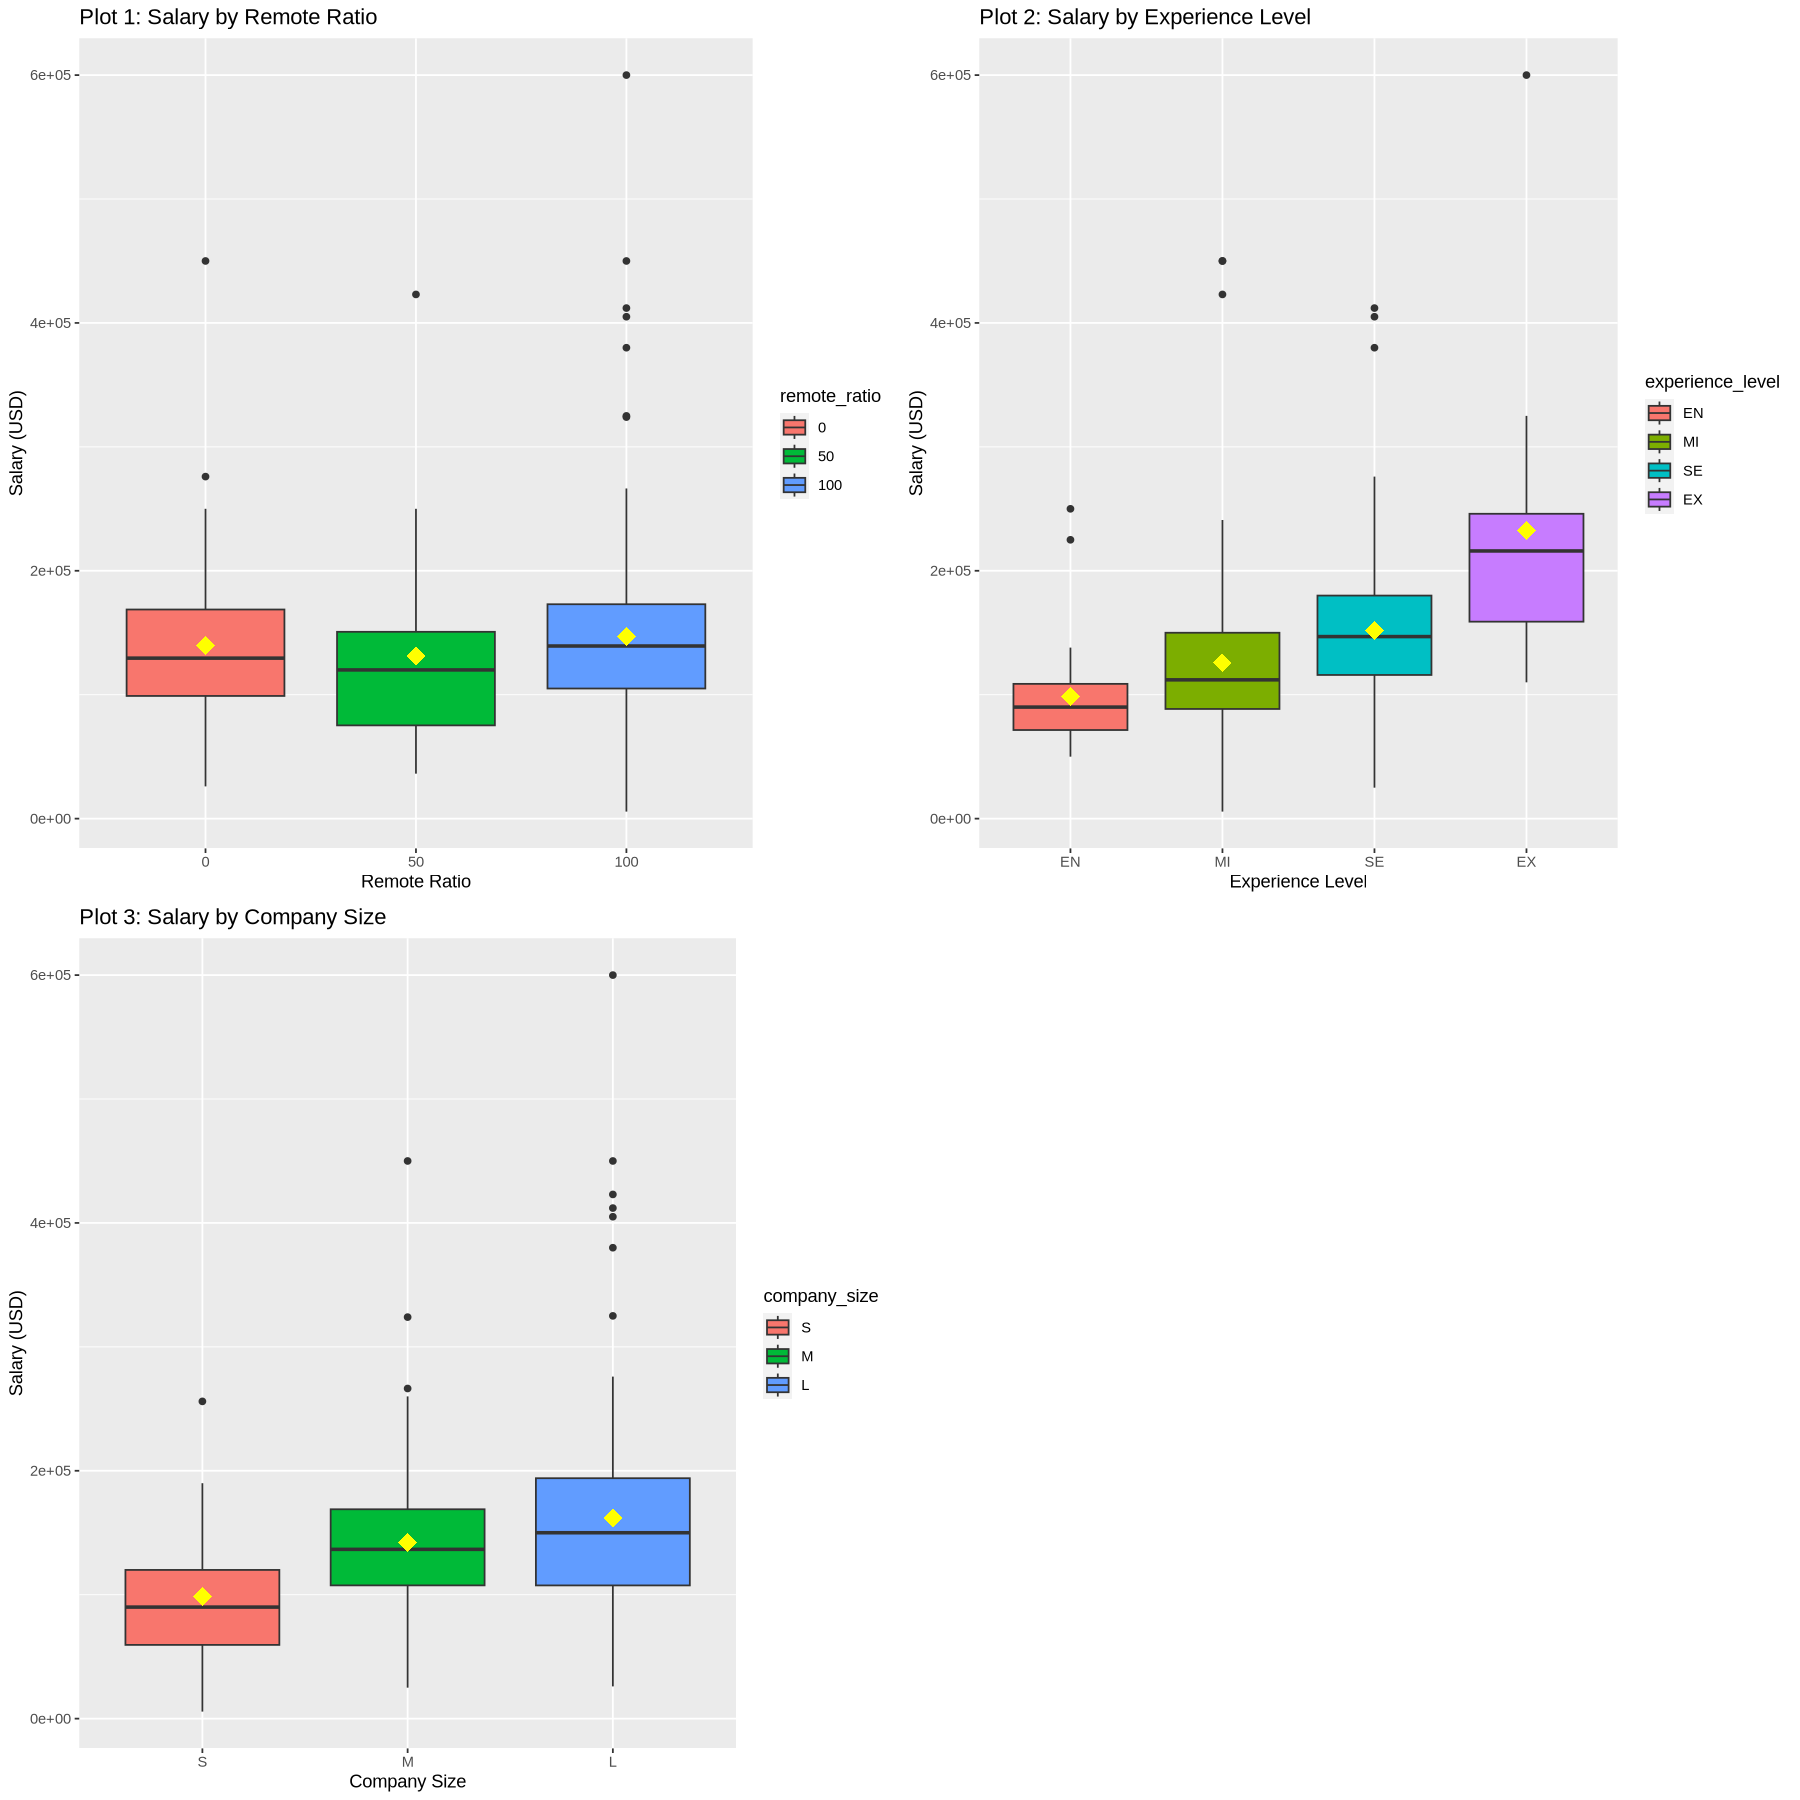

In [19]:
#Creating side-by-side boxplots for each explanatory variable

p1 <- ds_salaries %>%
    ggplot() +
    geom_boxplot(aes(x = remote_ratio, y = salary_in_usd, fill = remote_ratio)) +
    ggtitle("Plot 1: Salary by Remote Ratio") +
    xlab("Remote Ratio") +
    ylab("Salary (USD)")+
    stat_summary(aes(x = remote_ratio, y = salary_in_usd),
    fun = "mean", colour = "yellow", geom = "point",
    shape = 18, size = 5
  )

ds_salaries$experience_level <- factor(ds_salaries$experience_level, levels = c("EN", "MI", "SE", "EX"))

p2 <- ds_salaries %>%
    ggplot() +
    geom_boxplot(aes(x = experience_level, y = salary_in_usd, fill = experience_level)) +
    ggtitle("Plot 2: Salary by Experience Level") +
    xlab("Experience Level") +
    ylab("Salary (USD)")+
    stat_summary(aes(x = experience_level, y = salary_in_usd),
    fun = "mean", colour = "yellow", geom = "point",
    shape = 18, size = 5
  )

ds_salaries$company_size <- factor(ds_salaries$company_size, levels = c("S", "M", "L"))

p3 <- ds_salaries %>%
    ggplot() +
    geom_boxplot(aes(x = company_size, y = salary_in_usd, fill = company_size)) +
    ggtitle("Plot 3: Salary by Company Size") +
    xlab("Company Size") +
    ylab("Salary (USD)")+
    stat_summary(aes(x = company_size, y = salary_in_usd),
    fun = "mean", colour = "yellow", geom = "point",
    shape = 18, size = 5
  )

grid.arrange(p1, p2, p3,  nrow = 2)

Upon examining the visualization, we observe that larger companies tend to offer higher average salaries as we can see that salary and experience level have a positive correlation. Additionally, we can see that experience level seems to also have a noticeable impact on salary, as there is a clear trend of the median and mean of salary increasing as the experience level increases. On the other hand, for remote ratio, the means and medians seem to be quite similar, indicating remote ratio may have a weaker impact on one's salary, and may not predict salary as well as the other variables as a result. 

### Methods: Plan 

**Part 1: Inference**

To perform the first part of our investigation, which is to infer the relationship between the response variable of salary (USD) and the input variables remote ratio, experience level and company size. To do this we will
first fit an additive multiple linear regression, which provided us with the estimate, standard error, statistic and p-value for the intercept, and each level for every input variable. This will allow us to do "feature selection", to select which covariates to use in our final predictive model.

In [20]:
# Fit an additive multiple linear regression model
mlr_model <- lm(salary_in_usd ~ experience_level + company_size + remote_ratio, data = ds_salaries)

# Display the summary of the model to see coefficients and statistics
tidy(mlr_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),75340.41,16258.85,4.633809,5.132718e-06
experience_levelMI,18654.74,13986.40,1.333777,1.831749e-01
experience_levelSE,51202.74,13475.40,3.799720,1.717663e-04
⋮,⋮,⋮,⋮,⋮
company_sizeL,47449.717,13681.140,3.4682576,0.0005915777
remote_ratio50,-5738.898,16357.459,-0.3508429,0.7259248035
remote_ratio100,4479.728,8457.793,0.5296568,0.5966976236


                        Table 1
                        

#### Interpretation: Coefficient Analysis

Here is our coefficient analysis based on the information provided by Table 1.

##### Experience Level
Experience level significantly influences salary outcomes, with the **entry level** serving as the reference category:

> **Mid Level (MI)**: The coefficient estimate is 18,655, suggesting that, compared to entry-level employees, mid-level employees earn about **$18,655**. However, this level is **not statistically significant** as the p-value is 0.183, which is greater than our established significance level of 0.05.

> **Senior Level (SE)**: The coefficient estimate is 51,203, suggesting that, compared to entry-level employees, senior level employees earn about **$51,203** more. This level is **statistically significant** as the p-value is 0.000172, which is smaller than our established significance level of 0.05.

> **Executive Level (EX)**: The coefficient estimate is 126,150, suggesting that, compared to entry-level employees, executive level employees earn about **$126,150** more. This level is **statistically significant** as the p-value is 0.00000000210, which is much smaller than our established significance level of 0.05.

##### Company Size
Company size also plays a crucial role in determining salary, with ***small companies*** used as the reference category:

> - **Medium Companies (M)**: Employees in medium-sized companies earn about **\$16156** more than those in small companies. However, the p-value is 0.232, deeming it **not statistically significant**. 

> - **Large Companies (L)**: Working in large companies is associated with an increase of approximately **\$47,450** in salary compared to small companies. The p-value is 0.000592, therefore it is **statistically significant**.

##### Remote Ratio
The p-values for both a remote ratio of 50% and 100% are much greater than 0.05, with 50% remote ratio having a p-value of 0.726 and 100% having a p-value of 0.597. Therefore, remote ratio is  **not** a statistically significant input variable. 

##### Statistical Significance
Company size and experience level show significant effects on salary at the **5%** significance level, while for the remote ratio does not. This provides strong evidence that the company size are indeed relevant factors in determining salary levels in the data science profession.


**Part 2: Prediction**

Next we will predict a data science salary while confirming that company size and experience level will contribute to predicting a data science salary while remote ratio will not. To do this we will:

First let's split our data into two parts, training sets and test sets. We chose **70%** for the **training set** and **30%** for the **testing set**. We will train the model using the training set, and test the model with the testing set to see its performance on unseen data.

In [23]:
#Setting the seed
set.seed(2001)

# Data Split Into Training & Testing Sets
training_ds  = ds_salaries %>%
  sample_frac(0.7)

testing_ds = ds_salaries %>%
  setdiff(training_ds)


# Forward Selection on training dataset
forward_selection <- regsubsets(
  x =  salary_in_usd ~ remote_ratio + experience_level + company_size, nvmax = 3,
  data = training_ds,
  method = "forward"
)

forward_selection_summary <- summary(forward_selection)

We will then be using the **forward selection** algorithm on the training set to select our model depending on the model with the best **Mallow's Cp** / **BIC** value, and select the feature variables that are relevant to the response variable.

In [24]:
# Forward Selection Summary Table
forward_selection_summary_df <- tibble(
    n_input_variables = 1:3,
    RSQ = forward_selection_summary$rsq,
    RSS = forward_selection_summary$rss,
    ADJ.R2 = forward_selection_summary$adjr2,
    Cp = forward_selection_summary$cp,
    BIC = forward_selection_summary$bic,
)

# Displaying Forward Selection Summary DF Showing best Mallow's CP Value is 10, and BIC is 5
forward_selection_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.03134120,970932721005,0.02730512,25.018600,3.271906
2,0.08680199,915341743966,0.07916016,11.959409,-5.507401
3,0.11972131,882345143420,0.10862536,5.020871,-8.903297


                              Table 2
                                

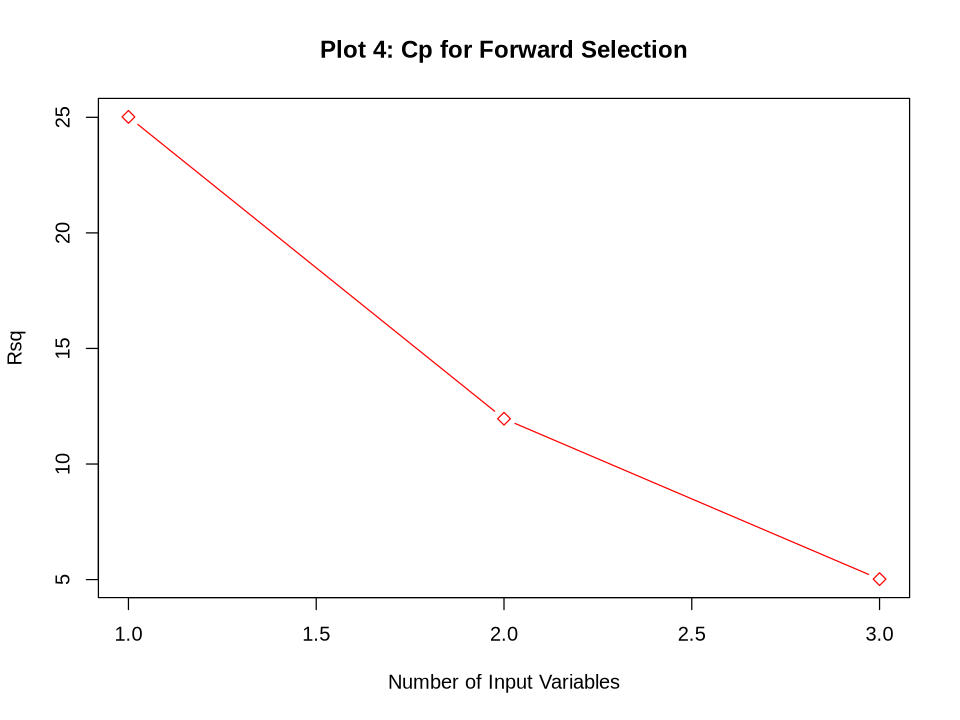

In [25]:
# plot to show all the $C_p$ of the models from forward selection algorithm
options(repr.plot.width = 8, repr.plot.height = 6)
plot(forward_selection_summary$cp,
  main = "Plot 4: Cp for Forward Selection",
  xlab = "Number of Input Variables", ylab = "Rsq", type = "b", pch = 5,
  col = "red"
)

We are going to use the model with variables selected by the best Mallow's Cp value, which is the minimum Cp value, 10

In [26]:
cp_min = which.min(forward_selection_summary$cp) 
selected_var <- names(coef(forward_selection, cp_min))[-1]
selected_var

[1] "experience_levelSE" "experience_levelEX" "company_sizeL"

Finally, we will evaluate the model. We will create a linear model using the selected input variables in an additive model, and then evaluate the performance of the linear model using the testing set. Since we expect to see a strong relationship between the selected feature variables that predict a data scientist's salary, we can judge how good the model is by the test **RMSE** that we obtain from using the function **rmse()** on the testing set and full model and compare the two.

In [27]:
# 3. Evaluate the Model:
# Use selected variables for Reduced Model based on the ones shown above.
training_subset <- training_ds %>% select(experience_level, company_size, salary_in_usd)
testing_subset <- testing_ds %>% select(experience_level, company_size, salary_in_usd)

# Reduced Model Using sub training dataset
da_salary_reduced_model <- lm(salary_in_usd ~  . , 
          data = training_subset)

# Full Model Using original training dataset
da_salary_full_model <- lm(salary_in_usd ~  . , 
          data = training_ds)

# Model Table With RMSE Value
model_table <- rbind(
  tibble(
  Model = "OLS Full Regression",
  RMSE = rmse(
        testing_ds$salary_in_usd,
        predict(da_salary_full_model, testing_ds)
      )
    ),
  tibble(
    Model = "OLS Reduced Regression",
    RMSE = rmse(
        testing_subset$salary_in_usd,
        predict(da_salary_reduced_model, testing_subset))
  )
)

# Displaying the model with RMSE Value
model_table

Model,RMSE
<chr>,<dbl>
OLS Full Regression,72307.87
OLS Reduced Regression,71880.34


#### Interpretation of Results

When comparing the Mallow's CP value of each number of variables, the levels showed that senior experience level, executive experience level and a large company size had the smallest values, which is consistent with our previous inference component (experience level and company size being statistically significant, while remote ratio being not statistically significant). 

Using the selected variables, experience level and company size, we built a reduced model and calculated the RMSE. From our calculated RMSE, the "OLS Full Regression" model has an RMSE of 72307.87, whereas the "OLS Reduced Regression" has an RMSE of 71880.34. The RMSE of the reduced model is lower than the full model, indicating a better fit to the data because the model's predictions are closer to the actual value. This suggests that the reduced model performs better at predicting the target variable on the test set. 

## Conclusion

**Findings**

The regression analysis reveals that experience level is a significant predictor of salary, with senior roles commanding higher pay, and executive roles enjoying the highest salary boost. Company size also plays a role, with professionals in larger organizations earning more. However, salary tends to vary with remote work ratio, as there is not a statistically significant association between remote ratio and salary. These results mostly aligned with our expectations as we expected all three input variables to be significant. However, we were surprised remote ratio was not significant, as there seems to be a trend towards valuing flexibility and an influx of remote work positions as a result. These insights directly address our research question by quantifying the extent to which experience, company size, and remote work capacity influence salaries in the data science field.

**Improvement of model**

Regularization techniques such as Ridge or LASSO regression could be used to prevent overfitting by adding a penalty term. Additionally, non-linear models could have been explored, such as logistic regression. A limitation of this dataset was that all the input variables were categorical, which made it difficult for us to explore other models. For example, one group member wanted to use LASSO to perform feature selection, however, due to the nature of the dataset, it would yield unideal results. Therefore, next time if a different dataset that included continuous variables for data science salaries were available, we would try to explore those models.  

**Future Questions/Research**
1. Remote Ratio: Since the remote work ratio was not found to be significant, it might be interesting to investigate why this is the case. Is it because remote work is equally distributed across different salary levels, or are there other factors that cause this?

2. Geographical Differences: Since our investigation focused only on data from the United States, a potential future question would be ow do these factors influence salaries in different geographical locations such as in India or Germany? This could lead to questions such as, "Are there locations where remote work has a more significant impact on salary?"

## References

Anderson, H. B. (2018, August 15). What data scientists really do, according to 35 data scientists. Harvard Business Review. https://hbr.org/2018/08/what-data-scientists-really-do-according-to-35-data-scientists

Davenport, T. H. (2022, July 15). Is data scientist still the sexiest job of the 21st century? Harvard Business Review. https://hbr.org/2022/07/is-data-scientist-still-the-sexiest-job-of-the-21st-century

Innovation, Science, Economic Development Canada. (2023, October 4). Firm-size wage gaps and hierarchy: Evidence from Canada. https://ised-isde.canada.ca/site/sme-research-statistics/en/research-reports/firm-size-wage-gaps-and-hierarchy-evidence-canada